# Seguridad y Privacidad de los Datos - 2024/25

Last edited: 2025/03/25

# 0. Train the model on the provided dataset

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
df.sample(10)

,sha256,label,timestamp,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,unused_permissions,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_

Cositas importantes:

* sha256 poco útil
* Ordenar en orden cronológico y dividir el entrenamiento (entrenar con las de hace 5 años y predecir actuales) dice que es interesante
* 'activities_count', 'providers_count','receivers_count' parecen interesantes según él
* 'api_calls_count' interesante
* 'unused_permissions' permisos pedidos pero no usados
* 'urls_count' cuantas urls se han encontrado dentro de la apk
* Probar varios modelos e ir quitando/poniendo caracteristicas
* Hay varias columnas con sus, que son llamadas a la api
* Hay que intentar hacer un modelo no muy bueno al principio para que sea bueno en general

In [3]:
df.columns

Index(['sha256', 'label', 'timestamp', 'activities_count', 'providers_count',
       'receivers_count', 'features_count', 'intent_filters_count',
       'api_calls_count', 'urls_count',
       ...
       'susp_getNetworkCountryIso', 'susp_getPackageInfo',
       'susp_getSimCountryIso', 'susp_getSubscriberId',
       'susp_getSystemService', 'susp_getWifiState', 'susp_sendTextMessage',
       'susp_setWifiDisabled', 'susp_setWifiEnabled', 'susp_system/bin/su'],
      dtype='object', length=358)

In [4]:
df.value_counts("label")

label
0    67771
1     7519
dtype: int64

In [5]:
# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

df.sample(10)

,label,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_PUSH,perm_android.permission.CACHE_C

In [6]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56467, 354), (18823, 354), (56467,), (18823,))

In [7]:
# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model on the training set
train_accuracy = rf_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_accuracy = rf_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9993
Test Accuracy: 0.9808


# 1. Perform at least one black-box attack and one white-box attack on the model. You may perform additional attacks as desired.

- Black box
- White box

## Black Box

In [8]:
import numpy as np

# Function to perform a black-box attack by perturbing the input features
def black_box_attack(samples, feature_columns, epsilon=0.1):
    """
    Perform a black-box attack by adding small perturbations to the input features
    for a list of samples, taking into account range-based and one-hot encoded columns.
    
    Parameters:
    - samples: Input samples (DataFrame) to perturb
    - feature_columns: List of feature column names
    - epsilon: Magnitude of the perturbation
    
    Returns:
    - perturbed_samples: Perturbed input samples
    """
    # Separate columns into range-based and one-hot encoded
    range_columns = [col for col in feature_columns if col.endswith('_count')]
    one_hot_columns = [col for col in feature_columns if col not in range_columns]
    
    # Convert the samples to a numpy array
    samples_array = samples.values.astype(float)
    
    # Generate perturbations for range-based columns
    range_indices = [samples.columns.get_loc(col) for col in range_columns]
    range_perturbations = np.random.uniform(-epsilon, epsilon, (samples_array.shape[0], len(range_indices)))
    samples_array[:, range_indices] += range_perturbations
    samples_array[:, range_indices] = np.rint(samples_array[:, range_indices])
    samples_array[:, range_indices] = np.clip(samples_array[:, range_indices], 0, 100)  # Ensure valid range
    
    # Generate perturbations for one-hot encoded columns
    one_hot_indices = [samples.columns.get_loc(col) for col in one_hot_columns]
    one_hot_data = samples_array[:, one_hot_indices]
    noise = np.random.laplace(loc=0.0, scale=1/(epsilon+10e6), size=one_hot_data.shape)
    one_hot_data = np.clip(one_hot_data + noise, 0, 1)  # Ensure values remain in [0, 1]
    one_hot_data = np.rint(one_hot_data)  # Round to maintain one-hot encoding
    samples_array[:, one_hot_indices] = one_hot_data
    
    # Create the perturbed samples DataFrame
    perturbed_samples = samples.copy()
    perturbed_samples.iloc[:, :] = samples_array
    
    return perturbed_samples

# Select a sample from the test set
sample_index = 0  # Change this index to select different samples
original_sample = X_test.iloc[sample_index:sample_index + 1]

# Perform the black-box attack
epsilon = 30  # Magnitude of perturbation
perturbed_sample = black_box_attack(original_sample.copy(), X_test.columns, epsilon)

# Predict the label for the original and perturbed samples
original_prediction = rf_model.predict(original_sample)[0]
perturbed_prediction = rf_model.predict(perturbed_sample)[0]

# Print the results
print("Original Sample Prediction:", original_prediction)
print("Perturbed Sample Prediction:", perturbed_prediction)
print("Ground Truth Label:", y_test.iloc[sample_index])

Original Sample Prediction: 1
Perturbed Sample Prediction: 0
Ground Truth Label: 1


In [9]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

# Define a range of epsilon values to test
epsilon_values = [0, 1, 2, 4, 8, 16, 32, 64, 128]
# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Evaluate the model for each epsilon value
for epsilon in tqdm(epsilon_values, desc="Evaluating epsilon values"):
    # Generate perturbed samples for all rows in X_test
    perturbed_samples = black_box_attack(X_test.copy(), X_test.columns, epsilon)
    
    # Get predictions for the perturbed samples
    perturbed_predictions = rf_model.predict(perturbed_samples)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, perturbed_predictions)
    precision = precision_score(y_test, perturbed_predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, perturbed_predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, perturbed_predictions, average='weighted', zero_division=0)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

Evaluating epsilon values: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the labels for X_test
y_pred = rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9808
Precision: 0.9805
Recall: 0.9808
F1 Score: 0.9802


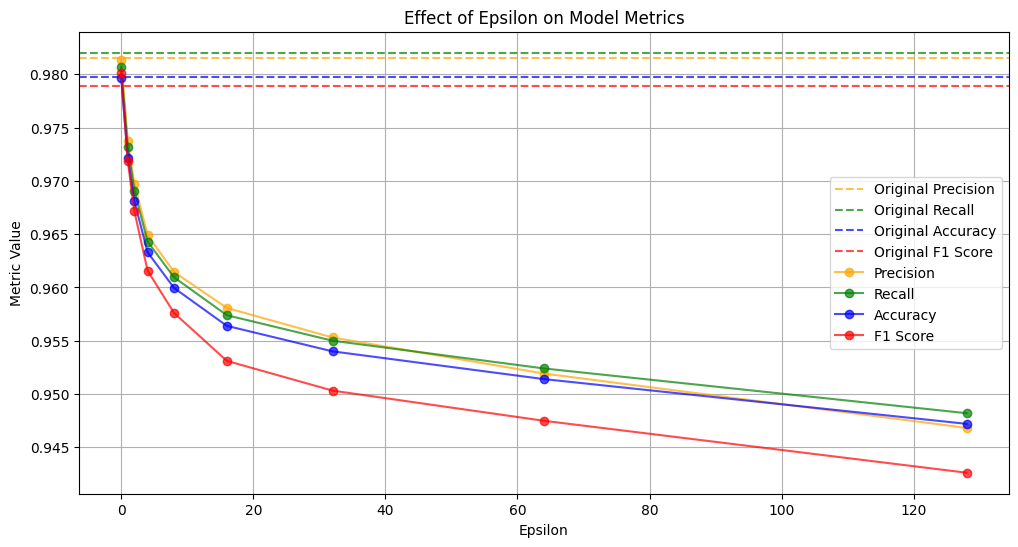

In [11]:
plt.figure(figsize=(12, 6))

# Define a small offset to avoid overlapping lines
offset = 0.001

# Plot original scores as dotted lines with slight offsets
plt.axhline(precision + offset, color='orange', linestyle='--', label='Original Precision', alpha=0.7)
plt.axhline(recall + 1.25*offset, color='green', linestyle='--', label='Original Recall', alpha=0.7)
plt.axhline(accuracy - offset, color='blue', linestyle='--', label='Original Accuracy', alpha=0.7)
plt.axhline(f1- 1.25*offset, color='red', linestyle='--', label='Original F1 Score', alpha=0.7)

# Plot metrics for different epsilon values
plt.plot(epsilon_values, np.array(precisions) + offset, label='Precision', marker='o', color='orange', alpha=0.7)
plt.plot(epsilon_values, np.array(recalls), label='Recall', marker='o', color='green', alpha=0.7)
plt.plot(epsilon_values, np.array(accuracies) - offset, label='Accuracy', marker='o', color='blue', alpha=0.7)
plt.plot(epsilon_values, np.array(f1_scores), label='F1 Score', marker='o', color='red', alpha=0.7)

# Add labels, legend, and grid
plt.title('Effect of Epsilon on Model Metrics')
plt.xlabel('Epsilon')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.show()

## White Box

In [12]:
# Obtener las características más importantes
feature_importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
importance_df.head(10)

,Feature,Importance
6,urls_count,0.075580
5,api_calls_count,0.069978
347,susp_getSubscriberId,0.048456
0,activities_count,0.046142
204,perm_android.permission.MOUNT_UNMOUNT_FILESYSTEMS,0.038916
298,perm_android.permission.SYSTEM_ALERT_WINDOW,0.037387
154,perm_android.permission.GET_TASKS,0.035382
4,intent_filters_count,0.029296
7,services_count,0.027444
2,receivers_count,0.025658


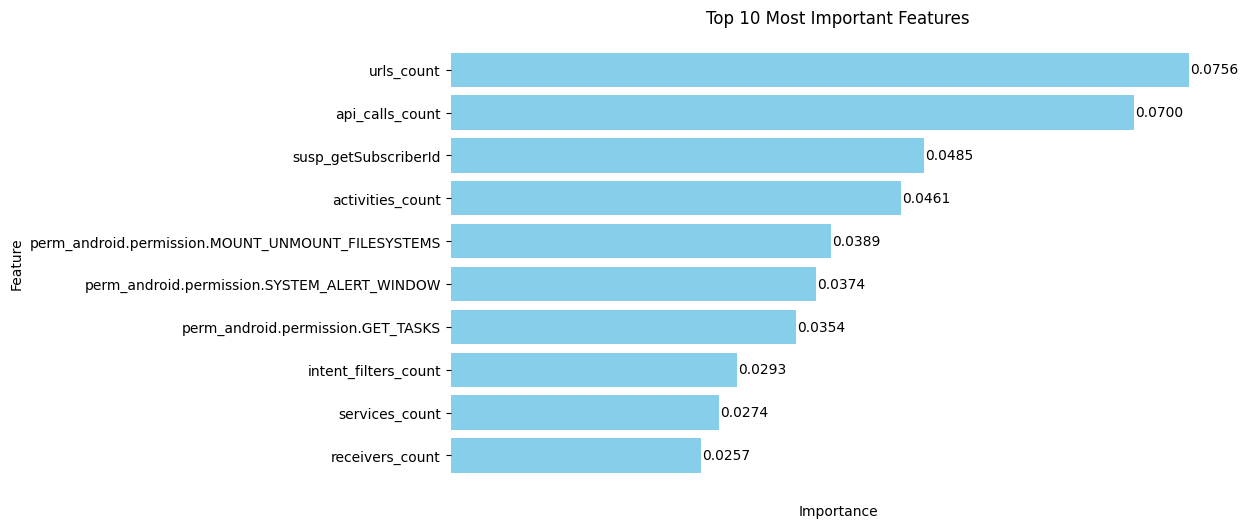

In [65]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()

# Remove the graph container border (axis)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Remove ticks
plt.xticks([])

# Add text labels for each bar
for bar in bars:
    plt.text(bar.get_width() + 1e-4, bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.4f}', va='center')

plt.show()

In [14]:
import seaborn as sns

# Estadísticas descriptivas de urls_count por label
urls_count_stats = df.groupby('label')['urls_count'].describe()
print(urls_count_stats)

         count       mean       std  min   25%   50%   75%     max
label                                                             
0      67771.0  44.890661  77.88022  0.0  17.0  30.0  51.0  6297.0
1       7519.0  48.302301  82.87415  0.0   0.0  15.0  61.0  1983.0


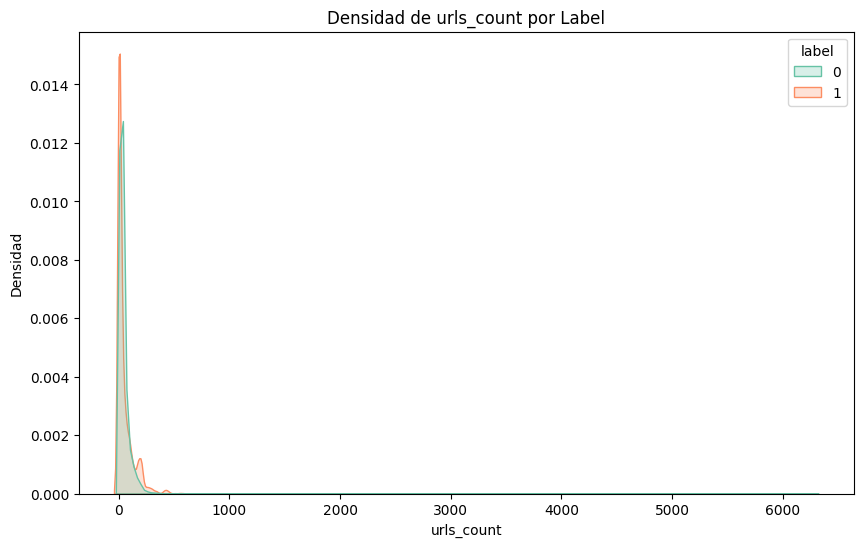

In [15]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='urls_count', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de urls_count por Label')
plt.xlabel('urls_count')
plt.ylabel('Densidad')
plt.show()

C:\Users\alexg\AppData\Local\Temp\ipykernel_21108\821809998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='urls_count', palette='Set2')


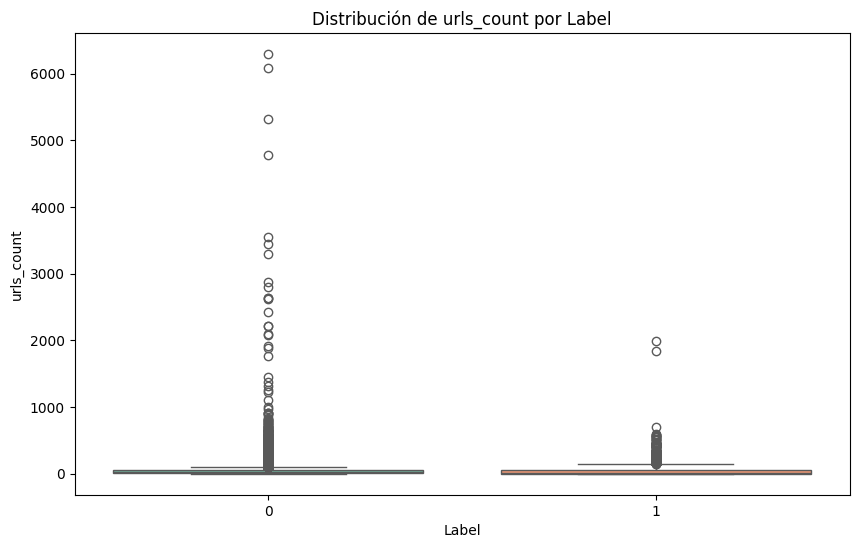

In [16]:
# Visualización de la distribución de urls_count por label
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='urls_count', palette='Set2')
plt.title('Distribución de urls_count por Label')
plt.xlabel('Label')
plt.ylabel('urls_count')
plt.show()

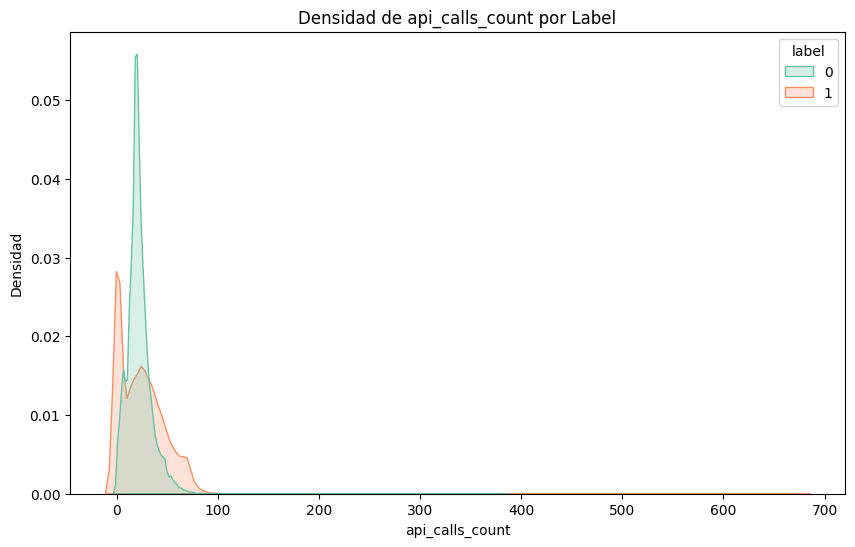

In [17]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='api_calls_count', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de api_calls_count por Label')
plt.xlabel('api_calls_count')
plt.ylabel('Densidad')
plt.show()

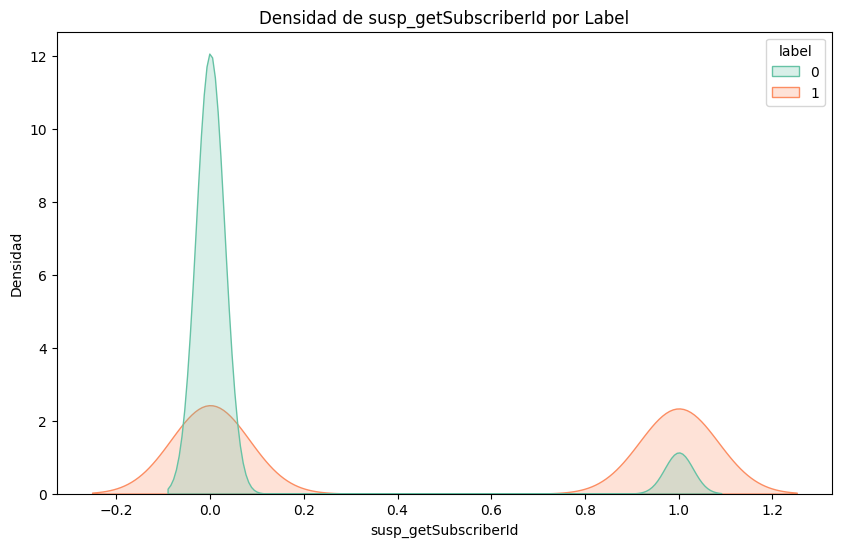

In [66]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='susp_getSubscriberId', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de susp_getSubscriberId por Label')
plt.xlabel('susp_getSubscriberId')
plt.ylabel('Densidad')
plt.show()

In [19]:
mean_api_calls_count_label_0 = df[df['label'] == 0]['api_calls_count'].mean()
mean_urls_count_label_0 = df[df['label'] == 0]['urls_count'].mean()
mean_susp_getSubscriberId_label_0 = df[df['label'] == 0]['susp_getSubscriberId'].mean()

print(f"Mean of api_calls_count when label is 0: {mean_api_calls_count_label_0}")
print(f"Mean of urls_count when label is 0: {mean_urls_count_label_0}")
print(f"Mean of susp_getSubscriberId when label is 0: {mean_susp_getSubscriberId_label_0}")

Mean of api_calls_count when label is 0: 21.575231293621165
Mean of urls_count when label is 0: 44.89066119726727
Mean of susp_getSubscriberId when label is 0: 0.08549379528116746


In [20]:
# Seleccionar una fila del conjunto de prueba
sample_index = 0  # Cambia este índice para probar con diferentes filas
sample_row = X_test.iloc[sample_index:sample_index + 1]

atack_sample_row = X_test.iloc[sample_index:sample_index + 1].copy()
atack_sample_row["urls_count"] = round(mean_urls_count_label_0)
atack_sample_row["api_calls_count"] = round(mean_api_calls_count_label_0)
atack_sample_row["susp_getSubscriberId"] = round(mean_susp_getSubscriberId_label_0)

# Mostrar la fila seleccionada
print("Sample Row:")
print(sample_row[['urls_count', 'api_calls_count', 'susp_getSubscriberId']])
print("\nAtack Sample Row:")
print(atack_sample_row[['urls_count', 'api_calls_count', 'susp_getSubscriberId']])

# Realizar la predicción
predicted_label = rf_model.predict(sample_row)[0]
atack_label = rf_model.predict(atack_sample_row)[0]

# Obtener el ground truth
ground_truth_label = y_test.iloc[sample_index]

# Imprimir los resultados
print(f"\nPredicted Label: {predicted_label}")
print(f"Atack Predicted Label: {atack_label}")
print(f"Ground Truth Label: {ground_truth_label}")

Sample Row:
      urls_count  api_calls_count  susp_getSubscriberId
5607          13               22                     1

Atack Sample Row:
      urls_count  api_calls_count  susp_getSubscriberId
5607          45               22                     0

Predicted Label: 1
Atack Predicted Label: 0
Ground Truth Label: 1


# 2. Prove that your model can be more robust to adversarial examples

Demonstrate that your model maintains high accuracy when subjected to adversarial examples. Provide empirical evidence of robustness by evaluating performance under adversarial attacks.

What Will Be Valued:
- Effective adversarial attack methods and proper defense mechanisms.
- Clear evaluation metrics comparing standard vs. adversarial performance.
- Well-documented methodology and reproducibility of results.

In [21]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

epsilon = 30  # Magnitude of perturbation

# Function to calculate metrics
def calculate_metrics(model, X, y_true):
    y_pred = model.predict(X)
    metrics = {
        'F1 Score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    return metrics

original_metrics = calculate_metrics(rf_model, X_test, y_test)
original_metrics

{'F1 Score': 0.9801907457937112,
 'Accuracy': 0.9807682091058811,
 'Recall': 0.9807682091058811,
 'Precision': 0.980505964914169}

In [22]:
# Perform a black-box attack
perturbed_samples_test = X_test.copy().apply(
    lambda row: black_box_attack(row.to_frame().T, X_test.columns, epsilon).iloc[0], axis=1
)

# Calculate metrics for the model under attack
perturbed_predictions = rf_model.predict(perturbed_samples_test)

attacked_metrics = calculate_metrics(rf_model, perturbed_samples_test, y_test)
attacked_metrics

{'F1 Score': 0.9500841532468566,
 'Accuracy': 0.9547893534505658,
 'Recall': 0.9547893534505658,
 'Precision': 0.9540309373684392}

In [24]:
# Identify successful attacks
successful_attacks = perturbed_predictions != y_test.values

# Create a DataFrame with successful attacks
successful_attacks_df = X_test[successful_attacks].copy()
successful_attacks_df['Ground Truth'] = y_test[successful_attacks]
successful_attacks_df['Perturbed Prediction'] = perturbed_predictions[successful_attacks]

# Display the DataFrame
successful_attacks_df.head()

,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_PUSH,perm_android.permission.CACHE_CONTENT

In [25]:
# Generamos muestras perturbadas del conjunto de entrenamiento
perturbed_X_train = X_train.apply(
    lambda row: black_box_attack(row.to_frame().T, X_train.columns, epsilon).iloc[0], axis=1
)

# Concatenamos las muestras originales y perturbadas
X_train_robust = pd.concat([X_train, perturbed_X_train], axis=0)
y_train_robust = pd.concat([y_train, y_train], axis=0)

# Entrenamos un nuevo modelo robusto
rf_model_robust = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_robust.fit(X_train_robust, y_train_robust)

# Evaluamos el modelo robusto en datos limpios y atacados
original_metrics_robust = calculate_metrics(rf_model_robust, X_test, y_test)
original_metrics_robust

{'F1 Score': 0.9796381168727177,
 'Accuracy': 0.9802369441640546,
 'Recall': 0.9802369441640546,
 'Precision': 0.9799454756604603}

In [26]:
perturbed_predictions_robust = rf_model_robust.predict(perturbed_samples_test)

attacked_metrics_robust = calculate_metrics(rf_model_robust, perturbed_samples_test, y_test)
attacked_metrics_robust

{'F1 Score': 0.9681680321118245,
 'Accuracy': 0.9699304042926208,
 'Recall': 0.9699304042926208,
 'Precision': 0.969527590771432}

In [47]:
good_app_count, malware_samples_count = y_train_robust.value_counts()
good_app_count, malware_samples_count

(101656, 11278)

In [48]:
# Split the training data into two subsets based on the target value
X_train_robust_0 = X_train_robust[y_train_robust == 0]
y_train_robust_0 = y_train_robust[y_train_robust == 0]

X_train_robust_1 = X_train_robust[y_train_robust == 1]
y_train_robust_1 = y_train_robust[y_train_robust == 1]

# Create splits for subset A
X_train_split_a = pd.concat([
    X_train_robust_0,
    X_train_robust_1
])
y_train_split_a = pd.concat([
    pd.Series(1, index=X_train_robust_0.index),
    pd.Series(0, index=X_train_robust_1.index)
])

# Create splits for subset B
X_train_split_b = pd.concat([
    X_train_robust_0.sample(malware_samples_count, random_state=42),
    X_train_robust_1
])
y_train_split_b = pd.concat([
    pd.Series(0, index=X_train_robust_0.sample(malware_samples_count, random_state=42).index),
    pd.Series(1, index=X_train_robust_1.index)
])

In [51]:
rf_model_0 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_0.fit(X_train_split_a, y_train_split_a)

rf_model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_1.fit(X_train_split_b, y_train_split_b)

class CombinedRandomForest:
    def __init__(self, model_0, model_1, model_2):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_2 = model_2
        self.inner_model = RandomForestClassifier(n_estimators=100, random_state=42)

    def fit(self, X, y):
        """
        Fit the combined model using X and y.
        The predictions from model_0, model_1, and model_2 are used as additional features.
        """
        # Get probabilities from the base models
        prob_0 = self.model_0.predict_proba(X)[:, 1]
        prob_1 = self.model_1.predict_proba(X)[:, 1]
        prob_2 = self.model_2.predict_proba(X)[:, 1]

        # Combine the original features with the probabilities
        X_combined = X.copy()
        X_combined['prob_0'] = prob_0
        X_combined['prob_1'] = prob_1
        X_combined['prob_2'] = prob_2

        # Fit the inner model
        self.inner_model.fit(X_combined, y)

    def predict(self, X):
        """
        Predict the labels using the combined model.
        """
        # Get probabilities from the base models
        prob_0 = self.model_0.predict_proba(X)[:, 1]
        prob_1 = self.model_1.predict_proba(X)[:, 1]
        prob_2 = self.model_2.predict_proba(X)[:, 1]

        # Combine the original features with the probabilities
        X_combined = X.copy()
        X_combined['prob_0'] = prob_0
        X_combined['prob_1'] = prob_1
        X_combined['prob_2'] = prob_2

        # Predict using the inner model
        return self.inner_model.predict(X_combined)

In [54]:
combined_rf = CombinedRandomForest(rf_model_0, rf_model_1, rf_model_robust)
combined_rf.fit(X_train_robust, y_train_robust)

original_metrics_robust_combined = calculate_metrics(combined_rf, X_test, y_test)
original_metrics_robust_combined

{'F1 Score': 0.9813755834958122,
 'Accuracy': 0.9817244860011688,
 'Recall': 0.9817244860011688,
 'Precision': 0.9813933275231391}

In [55]:
combined_rf = CombinedRandomForest(rf_model_0, rf_model_1, rf_model_robust)
combined_rf.fit(X_train_robust, y_train_robust)

attacked_metrics_robust_combined = calculate_metrics(combined_rf, perturbed_samples_test, y_test)
attacked_metrics_robust_combined

{'F1 Score': 0.9710292014349777,
 'Accuracy': 0.972161717048292,
 'Recall': 0.972161717048292,
 'Precision': 0.9714427200935681}

In [56]:
# Actualizamos el DataFrame de métricas
metrics_df = pd.DataFrame(
    [original_metrics, attacked_metrics, original_metrics_robust, attacked_metrics_robust, original_metrics_robust_combined, attacked_metrics_robust_combined],
    index=['Original', 'Black-Box Attack', 'Robust Model', 'Robust Model Under Attack', 'Robust Ensemble', 'Robust Ensemble Under attack']
)

metrics_df

,F1 Score,Accuracy,Recall,Precision
Original,0.980191,0.980768,0.980768,0.980506
Black-Box Attack,0.950084,0.954789,0.954789,0.954031
Robust Model,0.979638,0.980237,0.980237,0.979945
Robust Model Under Attack,0.968168,0.969930,0.969930,0.969528
Robust Ensemble,0.981376,0.981724,0.981724,0.981393
Robust Ensemble Under attack,0.971029,0.972162,0.972162,0.971443


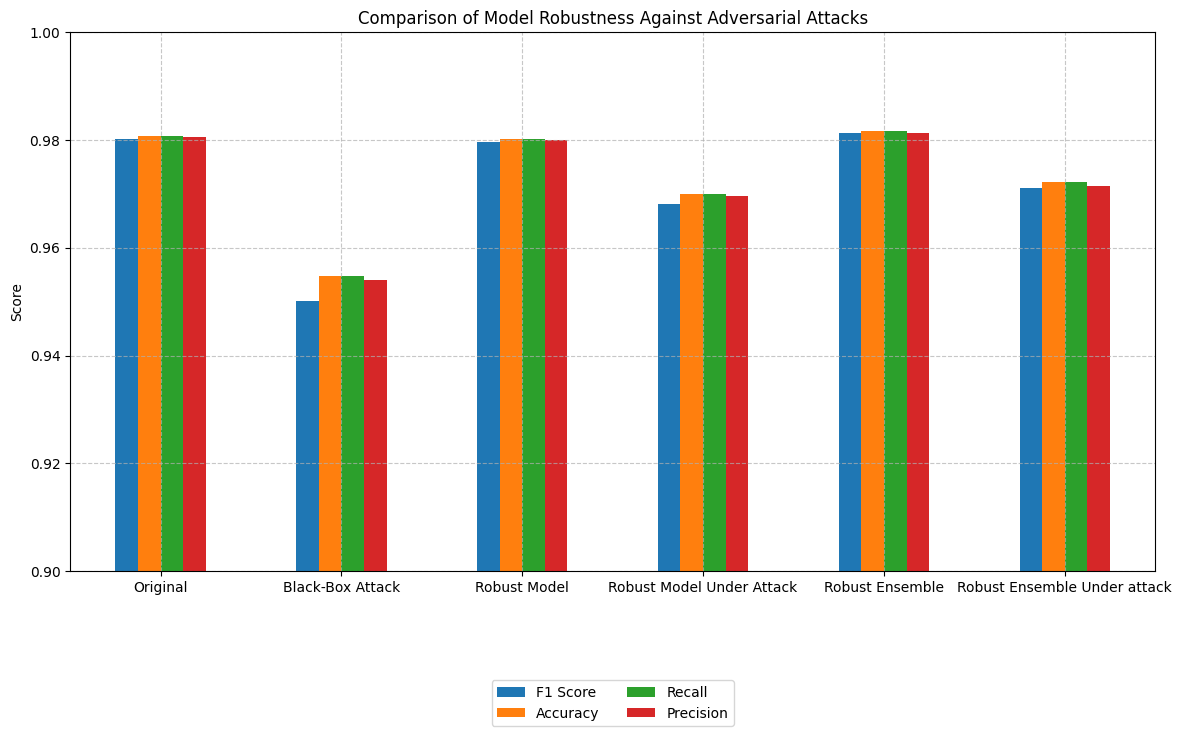

In [57]:
# Plot with zoomed-in y-axis
metrics_df.plot(kind='bar', figsize=(14, 7))
plt.title('Comparison of Model Robustness Against Adversarial Attacks')
plt.ylabel('Score')
plt.ylim(0.9, 1)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.show()

# 3. Try to attack this model

You will be given the anonymous model `android_permission_model.onnx`, previously trained on the provided dataset. 
Analyze the model’s weaknesses by testing different black-box attack strategies.

What Will Be Valued:
- Use of diverse adversarial attack techniques.
- Quantitative analysis of attack effectiveness with relevant metrics.
- Clear documentation of the attack process and reproducibility.

Below, you can find an example on model loading and inference. The model expects every column in the dataset except for `sha256`, `timestamp` and `unused_permissions`.
The model is loaded in an [onnx runtime](https://onnxruntime.ai/docs/api/python/api_summary.html). 

In [95]:
import os
import numpy as np
import pandas as pd
import onnxruntime as rt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
model_path = 'android_permission_model.onnx'

# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

# features and target separation + train/test split
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Example inference function using [sess.run()](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession.run):

In [96]:
def onnx_inference(model_path, test_data):
    """
    Function to load and make predictions with an ONNX model
    """
    # open ONNX inference session
    sess = rt.InferenceSession(model_path)
    
    # input and output names
    input_name = sess.get_inputs()[0].name
    output_names = [output.name for output in sess.get_outputs()]
    
    # send inputs to the model and obtain predictions
    results = sess.run(output_names, {input_name: test_data.astype(np.float32)})

    return results[0]       # results[0] are discrete predicted labels, while results[1] are probabilities

In [97]:
# try and load the model
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    # small sample to test if it works
    test_sample = X_test.iloc[:5].values
    onnx_predictions = onnx_inference(model_path, test_sample)
    
    if onnx_predictions is not None:
        print("\nONNX Model Predictions (sample):")
        print(onnx_predictions)
        
        # compare with actual labels
        actual_labels = y_test.iloc[:5].values
        print("\nActual labels:")
        print(actual_labels)
    
    # full test set now
    print("\nONNX Model Predictions (full test set):")
    full_predictions = onnx_inference(model_path, X_test.values)

    try:
        print(f"Accuracy: {accuracy_score(y_test, full_predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, full_predictions))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, full_predictions))
    except Exception as e:
        print(f"Error during ONNX prediction: {e}")


ONNX Model Predictions (sample):
[1 0 0 0 1]

Actual labels:
[1 0 0 0 0]

ONNX Model Predictions (full test set):
Accuracy: 0.9815

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16943
           1       0.86      0.97      0.91      1880

    accuracy                           0.98     18823
   macro avg       0.93      0.98      0.95     18823
weighted avg       0.98      0.98      0.98     18823


Confusion Matrix:
[[16642   301]
 [   48  1832]]


In [98]:
X_train.columns

Index(['activities_count', 'providers_count', 'receivers_count',
       'features_count', 'intent_filters_count', 'api_calls_count',
       'urls_count', 'services_count',
       'perm_android.permission.ACCESS_ALL_DOWNLOADS',
       'perm_android.permission.ACCESS_BLUETOOTH_SHARE',
       ...
       'susp_getNetworkCountryIso', 'susp_getPackageInfo',
       'susp_getSimCountryIso', 'susp_getSubscriberId',
       'susp_getSystemService', 'susp_getWifiState', 'susp_sendTextMessage',
       'susp_setWifiDisabled', 'susp_setWifiEnabled', 'susp_system/bin/su'],
      dtype='object', length=354)

In [99]:
# Generate synthetic data with proper handling of one-hot encoded columns
def generate_synthetic_data_with_one_hot(model_path, num_samples, feature_columns):
    """
    Generate synthetic data using the surrogate model, ensuring proper handling of one-hot encoded columns.
    
    Parameters:
    - surrogate_model: Trained surrogate model
    - num_samples: Number of synthetic samples to generate
    - feature_columns: List of feature column names
    
    Returns:
    - synthetic_data: DataFrame containing synthetic data
    """
    # Separate columns into `_count` and one-hot encoded columns
    count_columns = [col for col in feature_columns if col.endswith('_count')]
    one_hot_columns = [col for col in feature_columns if not col.endswith('_count')]
    
    # Generate random values for `_count` columns
    count_data = np.random.randint(0, 100, size=(num_samples, len(count_columns)))
    
    # Generate random one-hot encoded values
    one_hot_data = np.random.choice([0, 1], size=(num_samples, len(one_hot_columns)))
    
    # Combine all data into a single DataFrame
    synthetic_features = pd.DataFrame(
        np.hstack([count_data, one_hot_data]),
        columns=count_columns + one_hot_columns
    )
    
    # Predict labels using the surrogate model
    # Use the ONNX model for inference
    synthetic_labels = onnx_inference(model_path, synthetic_features.values)
    
    # Add the labels to the synthetic data
    synthetic_features['label'] = synthetic_labels
    
    return synthetic_features

In [100]:
from sklearn.ensemble import RandomForestClassifier

surrogate_model = RandomForestClassifier(random_state=42)

# Generate synthetic data
num_synthetic_samples = 10_000
synthetic_data = generate_synthetic_data_with_one_hot(model_path, num_synthetic_samples, X_train.columns)

# Train the surrogate model using synthetic data
X_synthetic = synthetic_data.drop('label', axis=1)
y_synthetic = synthetic_data['label']

surrogate_model.fit(X_synthetic, y_synthetic)

# Evaluate the surrogate model on the test set
surrogate_predictions = surrogate_model.predict(X_test)
print("Surrogate Model Evaluation with Synthetic Data:")
print(classification_report(y_test, surrogate_predictions))

Surrogate Model Evaluation with Synthetic Data:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     16943
           1       0.38      0.64      0.48      1880

    accuracy                           0.86     18823
   macro avg       0.67      0.76      0.70     18823
weighted avg       0.90      0.86      0.87     18823



In [114]:
def black_box_attack_with_surrogate(surrogate_model, onnx_model_path, test_data, feature_columns, epsilon=0.1):
    """
    Perform a black-box attack using the surrogate model to generate adversarial examples,
    taking into account one-hot encoded and range-based columns.
    
    Parameters:
    - surrogate_model: Trained surrogate model
    - onnx_model_path: Path to the ONNX model
    - test_data: Original test data (DataFrame)
    - feature_columns: List of feature column names
    - epsilon: Magnitude of the perturbation
    
    Returns:
    - adversarial_data: Adversarial examples (DataFrame)
    - original_predictions: Predictions of the ONNX model on the original test data
    - adversarial_predictions: Predictions of the ONNX model on the adversarial examples
    """
    # Separate columns into one-hot and range-based
    range_columns = [col for col in feature_columns if col.endswith('_count')]
    one_hot_columns = [col for col in feature_columns if col not in range_columns]
    
    # Predict probabilities using the surrogate model
    surrogate_probs = surrogate_model.predict_proba(test_data)
    
    # Generate perturbations for range-based columns
    perturbations = epsilon * np.sign(surrogate_probs[:, 1].reshape(-1, 1) - 0.5)
    range_perturbations = perturbations[:, :len(range_columns)]
    
    # Generate adversarial examples for range-based columns
    adversarial_range_data = test_data[range_columns].values + range_perturbations
    adversarial_range_data = np.clip(adversarial_range_data, 0, 100)  # Ensure valid range
    
    # For one-hot columns, randomly flip one-hot values using a mask
    adversarial_one_hot_data = test_data[one_hot_columns].values.copy()
    noise = np.random.laplace(loc=0.0, scale=1/(epsilon+10e6), size=adversarial_one_hot_data.shape)
    adversarial_one_hot_data = np.clip(adversarial_one_hot_data + noise, 0, 1)  # Ensure values remain in [0, 1]
    adversarial_one_hot_data = np.rint(adversarial_one_hot_data)  # Round to maintain one-hot encoding
    
    # Combine range-based and one-hot adversarial data
    adversarial_data = np.hstack([adversarial_range_data, adversarial_one_hot_data])
    
    # Get predictions from the ONNX model
    original_predictions = onnx_inference(onnx_model_path, test_data.values)
    adversarial_predictions = onnx_inference(onnx_model_path, adversarial_data)
    
    return adversarial_data, original_predictions, adversarial_predictions

# Perform the black-box attack
epsilon = 4  # Magnitude of perturbation
adversarial_data, original_predictions, adversarial_predictions = black_box_attack_with_surrogate(
    surrogate_model, model_path, X_test, X_train.columns, epsilon
)

# Evaluate the attack
print("Original ONNX Model Accuracy:", accuracy_score(y_test, original_predictions))
print("Adversarial ONNX Model Accuracy:", accuracy_score(y_test, adversarial_predictions))
print("\nConfusion Matrix (Adversarial):")
print(confusion_matrix(y_test, adversarial_predictions))

Original ONNX Model Accuracy: 0.9814588535302555
Adversarial ONNX Model Accuracy: 0.9621208096477714

Confusion Matrix (Adversarial):
[[16600   343]
 [  370  1510]]


In [115]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Define a range of epsilon values to test
epsilon_values = [0, 1, 2, 4, 8, 16, 32, 64, 128]

# Initialize lists to store metrics
accuracies = []
precision_scores = []
recall_scores = []

original_predictions = onnx_inference(model_path, X_test.values)
original_accuracy = accuracy_score(y_test, original_predictions)
original_precision = precision_score(y_test, original_predictions, average='weighted', zero_division=0)
original_recall = recall_score(y_test, original_predictions, average='weighted', zero_division=0)

# Evaluate the model for each epsilon value
for epsilon in epsilon_values:
    adversarial_data, _, adversarial_predictions = black_box_attack_with_surrogate(
        surrogate_model, model_path, X_test, X_train.columns, epsilon
    )
    
    accuracies.append(accuracy_score(y_test, adversarial_predictions))
    precision_scores.append(precision_score(y_test, adversarial_predictions, average='weighted', zero_division=0))
    recall_scores.append(recall_score(y_test, adversarial_predictions, average='weighted', zero_division=0))

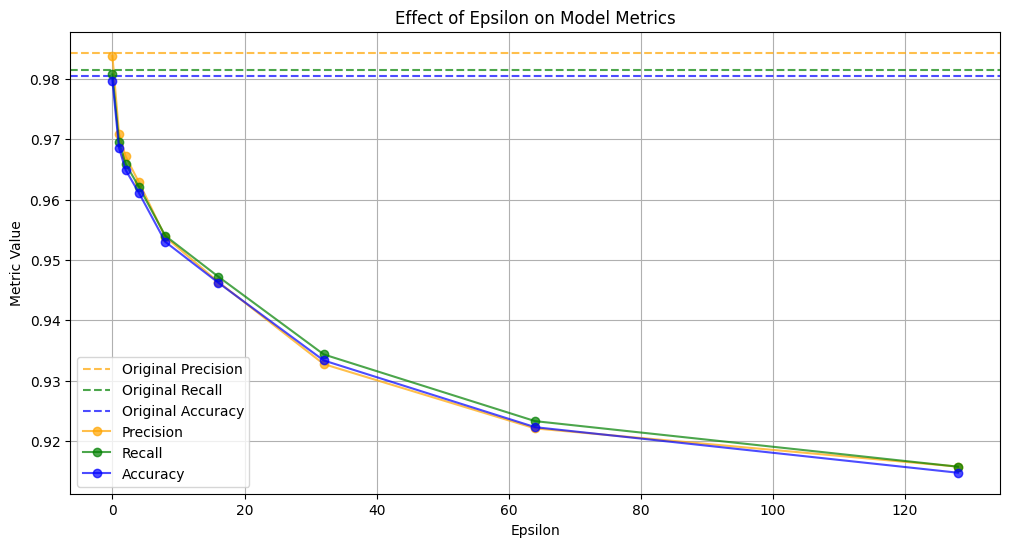

In [116]:
plt.figure(figsize=(12, 6))

# Define a small offset to avoid overlapping lines
offset = 0.001

# Plot original scores as dotted lines with slight offsets
plt.axhline(original_precision + offset, color='orange', linestyle='--', label='Original Precision', alpha=0.7)
plt.axhline(original_recall, color='green', linestyle='--', label='Original Recall', alpha=0.7)
plt.axhline(original_accuracy - offset, color='blue', linestyle='--', label='Original Accuracy', alpha=0.7)

# Plot metrics for different epsilon values
plt.plot(epsilon_values, np.array(precision_scores) + offset, label='Precision', marker='o', color='orange', alpha=0.7)
plt.plot(epsilon_values, np.array(recall_scores), label='Recall', marker='o', color='green', alpha=0.7)
plt.plot(epsilon_values, np.array(accuracies) - offset, label='Accuracy', marker='o', color='blue', alpha=0.7)

# Add labels, legend, and grid
plt.title('Effect of Epsilon on Model Metrics')
plt.xlabel('Epsilon')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.show()